# YOLO v1 

# Setup

In [6]:
import os
import sys
import json
import pathlib
from typing import (
    List,
    Dict,
    Tuple
)

import numpy as np
import tensorflow as tf
from tensorflow import keras   # MUST to make sure of using tensorflow.keras, not keras
from tensorflow.keras.models import (
    Model,
)
from tensorflow.keras.layers import (
    Layer,
    Normalization,
)
import tensorflow_datasets as tfds

## PYTHONPATH

In [3]:
path_to_lib: str = str(pathlib.Path(os.path.join(os.getcwd(), "../../..")).resolve())
assert isinstance(path_to_lib, str)
sys.path.append(path_to_lib)

In [31]:
%load_ext autoreload
%autoreload 2

from util_opencv.image import (
    get_image,
    show_image,
)
from util_tf.nn import (
    train,
    get_early_stopping_callback,
    get_tensorboard_callback,
)
from util_tf.tfds.voc import (
    generate_yolo_v1_label_from_pascal_voc,
    generate_yolo_v1_data_from_pascal_voc,
    PASCAL_VOC_CLASSES,
)

from constant import (
    DEBUG_LEVEL,
    TYPE_FLOAT,
    YOLO_V1_PREDICTION_NUM_CLASSES,
)
from model import (
    layers_config,
    input_shape,
    YOLOModel,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
# Data

## TFDS PASCAL VOC

In [7]:
voc, info = tfds.load(
    name='voc', 
    # split='train',
    data_dir="/Volumes/SSD/data/tfds/",
    with_info=True,
)
info

INFO:absl:No config specified, defaulting to config: voc/2007
INFO:absl:Load dataset info from /Volumes/SSD/data/tfds/voc/2007/4.0.0
INFO:absl:Reusing dataset voc (/Volumes/SSD/data/tfds/voc/2007/4.0.0)
INFO:absl:Constructing tf.data.Dataset voc for split None, from /Volumes/SSD/data/tfds/voc/2007/4.0.0


tfds.core.DatasetInfo(
    name='voc',
    full_name='voc/2007/4.0.0',
    description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge,
    corresponding to the Classification and Detection competitions.
    
    In the Classification competition, the goal is to predict the set of labels
    contained in the image, while in the Detection competition the goal is to
    predict the bounding box and label of each individual object.
    annotations.
    """,
    config_description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge
    2007, a.k.a. VOC2007.
    
    A total of 9963 images are included in this dataset, where each image
    contains a set of objects, out of 20 different classes, making a total of
    24640 annotated objects.
    
    """,
    homepage='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/',
    data_path='/Volumes/SSD/data/tfds/voc/2007/4.0.0',
    file_format=tfrecord,
    download_size=868

## YOLO v1 dataset

Dataset in ```(input,label)``` format where input is ```(448,448,3)``` RGB image and label is YOLO v1 label in ```(C,P)``` format where ```P=(cp,x,y,w,h)```.

In [42]:
train = voc['train'].flat_map(generate_yolo_v1_data_from_pascal_voc)

In [45]:
example = next(train.as_numpy_iterator())
image = example[0]
label = example[1]

### Input Image

(448, 448, 3)


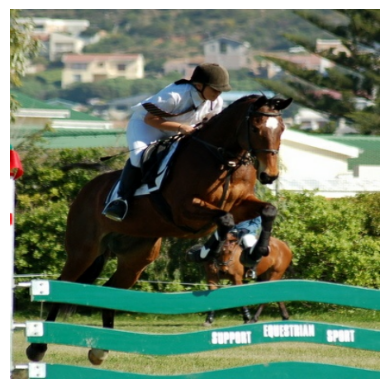

In [46]:
print(image.shape)
show_image(image=image.astype(np.uint8), bgr_to_rgb=False)

### Label

In [47]:
PASCAL_VOC_CLASSES[np.argmax(label[:YOLO_V1_PREDICTION_NUM_CLASSES]==1)]

'horse'

---

# Model

<img src="./image/architecture.png" align="left"/>


* yolo.cfg

```
[net]
batch=64
subdivisions=64
height=448
width=448
channels=3
momentum=0.9
decay=0.0005

learning_rate=0.001
policy=steps
steps=200,400,600,20000,30000
scales=2.5,2,2,.1,.1
max_batches = 40000

[crop]
crop_width=448
crop_height=448
flip=0
angle=0
saturation = 1.5
exposure = 1.5

[convolutional]
filters=64
size=7
stride=2
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
filters=192
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=1024
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=1024
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=1024
size=3
stride=1
pad=1
activation=leaky

#######

[convolutional]
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
size=3
stride=2
pad=1
filters=1024
activation=leaky

[convolutional]
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
size=3
stride=1
pad=1
filters=1024
activation=leaky

[connected]
output=4096
activation=leaky

[dropout]
probability=.5

[connected]
output= 1470
activation=linear

[detection]
classes=20
coords=4
rescore=1
side=7
num=2
softmax=0
sqrt=1
jitter=.2

object_scale=1
noobject_scale=.5
class_scale=1
coord_scale=5
```

In [4]:
input_shape

(448, 448, 3)

In [35]:
model: Model = YOLOModel()

Model: "yolo_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 448, 448, 3)]     0         
                                                                 
 norm (Normalization)        (None, 448, 448, 3)       7         
                                                                 
 conv01 (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 maxpool01 (MaxPooling2D)    (None, 112, 112, 64)      0         
                                                                 
 conv02 (Conv2D)             (None, 112, 112, 192)     110784    
                                                                 
 maxpool02 (MaxPooling2D)    (None, 56, 56, 192)       0         
                                                                 
 conv03_1 (Conv2D)           (None, 56, 56, 192)       3705

# Normalize

In [36]:
norm: Layer = model.get_layer(name="norm")

In [39]:
norm.axis   # standardize along axis=-1 (depth wise standardization where each pixel is a feature)

(-1,)

In [80]:
def f(*args):
    return args[0]

In [85]:
X_train = train.map(f)
for i in X_train.take(2):
    print(i.shape)

(448, 448, 3)
(448, 448, 3)


In [95]:
norm.adapt(data=X_train.take(20))

2023-03-09 17:51:34.221942: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at scatter_nd_op.cc:218 : INVALID_ARGUMENT: indices[0,0] = [0, -1] does not index into shape [1,20]


In [74]:
def f(*args):
    return args[0]

In [79]:
for i in train.take(2).map(f): 
    print(i.shape)

(448, 448, 3)
(448, 448, 3)


<tf.Tensor: shape=(), dtype=int64, numpy=-2>